In [1]:
import torch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import statistics
# import cv2
# from medpy.io import load
from sklearn.decomposition import PCA
import math
import copy
from tqdm import tqdm
from PIL import Image


In [2]:
# Omitting the posterior tissue in the segmentation
main_path = '../data/Task04_Hippocampus_processed/'
img_files = sorted(os.listdir(main_path+'imagesTr'))
seg_files = sorted(os.listdir(main_path+'labelsTr'))    

In [3]:
img = np.load(main_path+'imagesTr/'+img_files[0])
seg = np.load(main_path+'labelsTr/'+seg_files[0])

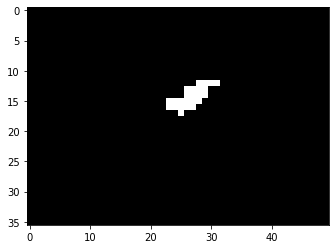

In [54]:
img_slice = img[:,:,5]
seg_slice = seg[:,:,8]
# seg_slice[seg_slice==2] = 0
plt.imshow(img_slice, cmap='gray')
plt.imshow(seg_slice, cmap='gray')
plt.show()

In [ ]:
def dotproduct(v1, v2):
    return np.abs(np.dot(v1, v2))

def length(v):
    return np.linalg.norm(v)

def distance(v1, v2):
    return np.linalg.norm(v1-v2)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle1(v1, v2):
  return np.arccos(dotproduct(v1, v2) / (length(v1) * length(v2)))

In [ ]:
def get_coords(seg):
    x = []
    y = []
    for i in range(seg.shape[1]):
        for j in range(seg.shape[0]):
            if seg[j][i] != 0:
                x.append(i)
                y.append(seg.shape[0] - j)
    if len(x) >1:
        x = np.array(x).reshape(-1,1).T
        y = np.array(y).reshape(-1,1).T
        data = np.concatenate((x,y), axis=0).T
        return data
    else:
        return None

def get_pca(data):
    pca = PCA(n_components=2)
    pca.fit(data)
    pca_comp = pca.components_
    mean_vec = pca.mean_
    return pca_comp, mean_vec

def get_axes(data, pca_comp, mean_vec):
    axis_length = np.zeros((2,1)).astype('float')
    for i in range(data.shape[0]):
        vec = data[i,:]
        angle_list = []
        for j in range(pca_comp.shape[0]):
            angle_list.append(angle1(vec-mean_vec, pca_comp[j]))

        for index, x in enumerate(angle_list):
            if x < 1.5*math.pi/180:
                dist = distance(mean_vec, vec)
                if dist > axis_length[index][0]:
                    axis_length[index] = dist

    for i in range(axis_length.shape[0]):
        if axis_length[i] == 0.0:
            axis_length[i] = 2
    return axis_length

def inside_outside_new(point, mean, axis_length, pca_comp, angle_vec):
    one = (np.cos(angle_vec)**2/axis_length[0][0]**2 + np.sin(angle_vec)**2/axis_length[1][0]**2)*((point[0]-mean[0]).astype('float'))**2
    two = (np.sin(angle_vec)**2/axis_length[0][0]**2 + np.cos(angle_vec)**2/axis_length[1][0]**2)*((point[1]-mean[1]).astype('float'))**2
    three = 2*(np.cos(angle_vec)*np.sin(angle_vec)*(1/axis_length[0][0]**2 - 1/axis_length[1][0]**2)*((point[0]-mean[0]).astype('float'))*((point[1]-mean[1]).astype('float')))
    if (one+two+three) <= 1:
        return True
    else:
        return False

def get_prior(seg):
    prior_slice = np.zeros_like(seg)
    data = get_coords(seg)
    if data is None:
        return prior_slice
    pca_comp, mean_vec = get_pca(data)
    axis_length = get_axes(data, pca_comp, mean_vec)
    angle_vec = angle1(pca_comp[0], np.array([10,0]))
    for i in range(seg.shape[1]):
        for j in range(seg.shape[0]):
            cond = inside_outside_new(np.array([[i,seg.shape[0] - j]]).reshape(2,-1), mean_vec, axis_length, pca_comp, angle_vec)
            if cond:
                prior_slice[j][i] = 1
    return prior_slice

def get_all_priors(seg_slice, num_classes):
    # num_classes = np.max(seg_slice).astype('int')+1
    class_list = list(np.unique(seg_slice.astype('int')))
    # print(class_list)
    for i in range(num_classes):
        if i==0:
            if i in class_list:
                seg = seg_slice.copy()
                full_prior = get_prior(seg)
            else:
                full_prior = np.zeros_like(seg_slice)
        if i==1:
            if i in class_list:
                seg = seg_slice.copy()
                seg[seg==2]=0
                left_prior = get_prior(seg)
            else:
                left_prior = np.zeros_like(seg_slice)
        if i==2:
            if i in class_list:
                seg = seg_slice.copy()
                seg[seg==1]=0
                right_prior = get_prior(seg)
            else:
                right_prior = np.zeros_like(seg_slice)
    if (num_classes>1):
        left_right_prior = right_prior.copy()
        left_right_prior[left_right_prior==1]=2
        left_right_prior += left_prior
        left_right_prior[left_right_prior==3]=2
    else:
        left_prior = full_prior
        right_prior = full_prior
        left_right_prior = full_prior
    # print(np.unique(seg_slice), np.unique(full_prior), np.unique(left_prior), np.unique(right_prior), np.unique(left_right_prior))
    return full_prior, left_prior, right_prior, left_right_prior

In [ ]:
def plot_priors(seg, full_prior, left_prior, right_prior, left_right_prior):
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1,5,1).imshow(seg, cmap='gray')
    plt.subplot(1,5,1).set_title('Segmentation GT')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,2).imshow(full_prior, cmap='gray')
    plt.subplot(1,5,2).set_title('Full Prior')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,3).imshow(left_prior, cmap='gray')
    plt.subplot(1,5,3).set_title('Ant Prior')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,4).imshow(right_prior, cmap='gray')
    plt.subplot(1,5,4).set_title('Post Prior')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,5).imshow(left_right_prior, cmap='gray')
    plt.subplot(1,5,5).set_title('Complete prior')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

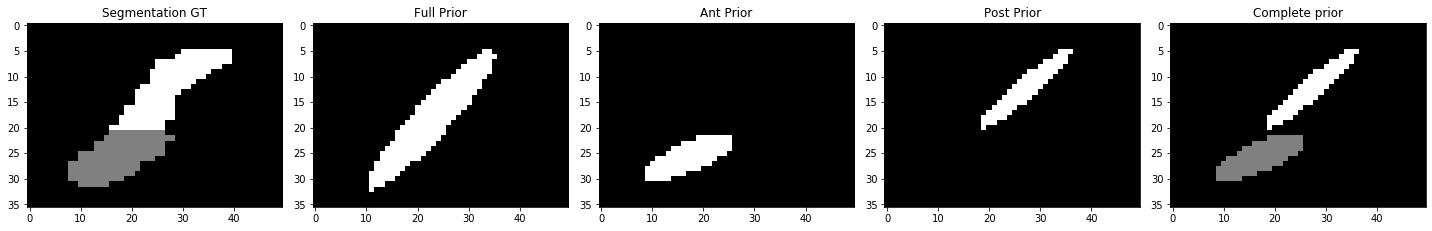

In [82]:
seg_slice = seg[:,:,15]
full_prior, left_prior, right_prior, left_right_prior = get_all_priors(seg_slice, 3)
plot_priors(full_prior, left_prior, right_prior, left_right_prior)

In [75]:
main_path = '../data/Task04_Hippocampus_processed/test/'
img_files = sorted(os.listdir(main_path+'imagesTest'))
seg_files = sorted(os.listdir(main_path+'labelsTest'))

In [80]:
for i in seg_files:
    seg = np.load(main_path+'labelsTest/'+i)
    for j in range(seg.shape[2]):
        seg_slice = seg[:,:,j]
        full_prior_slice, left_prior_slice, right_prior_slice, left_right_prior_slice = get_all_priors(seg_slice, 3)

        if j==0:
            full_prior = full_prior_slice
            full_prior = np.expand_dims(full_prior, axis=2)
            left_prior = left_prior_slice
            left_prior = np.expand_dims(left_prior, axis=2)
            right_prior = right_prior_slice
            right_prior = np.expand_dims(right_prior, axis=2)
            left_right_prior = left_right_prior_slice
            left_right_prior = np.expand_dims(left_right_prior, axis=2)
        else:
            full_prior = np.dstack((full_prior_slice,full_prior))
            left_prior = np.dstack((left_prior,left_prior_slice))
            right_prior = np.dstack((right_prior,right_prior_slice))
            left_right_prior = np.dstack((left_right_prior,left_right_prior_slice))
    folder_path = main_path+'prior/'
    np.save(folder_path+'full/'+i, full_prior)
    np.save(folder_path+'left/'+i, left_prior)
    np.save(folder_path+'right/'+i, right_prior)
    np.save(folder_path+'complete/'+i, left_right_prior)
    print(i, full_prior.shape, left_prior.shape, right_prior.shape, left_right_prior.shape)

201.npy (36, 50, 37) (36, 50, 37) (36, 50, 37) (36, 50, 37)
202.npy (36, 50, 37) (36, 50, 37) (36, 50, 37) (36, 50, 37)
203.npy (36, 50, 37) (36, 50, 37) (36, 50, 37) (36, 50, 37)
204.npy (36, 50, 33) (36, 50, 33) (36, 50, 33) (36, 50, 33)
205.npy (36, 50, 37) (36, 50, 37) (36, 50, 37) (36, 50, 37)
206.npy (36, 50, 33) (36, 50, 33) (36, 50, 33) (36, 50, 33)
207.npy (36, 50, 33) (36, 50, 33) (36, 50, 33) (36, 50, 33)
208.npy (36, 50, 34) (36, 50, 34) (36, 50, 34) (36, 50, 34)
209.npy (36, 50, 38) (36, 50, 38) (36, 50, 38) (36, 50, 38)
210.npy (36, 50, 35) (36, 50, 35) (36, 50, 35) (36, 50, 35)
211.npy (36, 50, 36) (36, 50, 36) (36, 50, 36) (36, 50, 36)
212.npy (36, 50, 36) (36, 50, 36) (36, 50, 36) (36, 50, 36)
213.npy (36, 50, 38) (36, 50, 38) (36, 50, 38) (36, 50, 38)
214.npy (36, 50, 34) (36, 50, 34) (36, 50, 34) (36, 50, 34)
215.npy (36, 50, 35) (36, 50, 35) (36, 50, 35) (36, 50, 35)
216.npy (36, 50, 35) (36, 50, 35) (36, 50, 35) (36, 50, 35)
217.npy (36, 50, 35) (36, 50, 35) (36, 5

In [6]:
# Omitting the posterior tissue in the segmentation
main_path = '../data/Spine_ct/Sagittal/Train/'
img_files = sorted(os.listdir(main_path+'Image'))
seg_files = sorted(os.listdir(main_path+'WholeMask'))    

In [7]:
pbar = tqdm(total=len(img_files), desc = 'Completed', leave=False)
count = 0
for i in img_files:
    seg_full = nib.load(main_path+'WholeMask/'+i)
    seg_full = seg_full.get_fdata()
    seg_lumbar =  nib.load(main_path+'Mask/'+i)
    seg_lumbar = seg_lumbar.get_fdata()
    if len(np.unique(seg_full))>2:
        img = nib.load(main_path+'Image/'+i)
        img = img.get_fdata()
        # print(img.shape)
        count+=1
        # fig = plt.figure(figsize=(6,2))
        # plt.subplot(1,3,1).imshow(img, cmap='gray')
        # plt.subplot(1,3,1).set_title('image')
        # plt.subplot(1,3,2).imshow(seg_full, cmap='gray')
        # plt.subplot(1,3,2).set_title('Full Seg')
        # plt.subplot(1,3,3).imshow(seg_lumbar, cmap='gray')
        # plt.subplot(1,3,3).set_title('Lumbar Seg')
        # plt.show()
        pbar.update(1)
    else:
        pbar.update(1)
        continue
print(count)

Completed: 100%|██████████| 28915/28915 [14:50<00:00, 66.85it/s]

In [37]:
print(img_files[60], seg_files[152])

10_slice29.nii.gz 10_slice28.nii.gz


In [55]:
img = nib.load(main_path+'Image/'+'1_slice102.nii.gz')
img = img.get_fdata()
seg = nib.load(main_path+'WholeMask/'+'1_slice102.nii.gz')
seg = seg.get_fdata()

In [56]:
img.shape

(571, 571)

In [57]:
np.unique(seg)

array([ 0.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
       19., 20., 21., 22., 23., 24.])

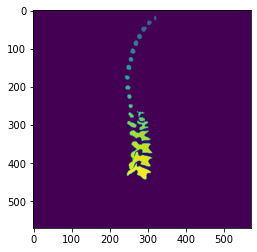

In [59]:
seg = np.rot90(seg, 1)
plt.imshow(seg)

In [50]:
# seg[seg!=24]=0

In [13]:
# np.unique(seg)

In [11]:
def inside_outside_pgram(point, axis_length, pca_comp, angle_vec):
    track_list = []
    track_list.append(np.dot(point, pca_comp[0])+axis_length[0])
    track_list.append(np.dot(point, pca_comp[0])-axis_length[0])
    track_list.append(np.dot(point, pca_comp[1])-axis_length[1])
    track_list.append(np.dot(point, pca_comp[1])-axis_length[1])
    # print(track_list)
    bool_list = []
    for i in track_list:
        if i < 0:
            bool_list.append(-1)
        else:
            bool_list.append(1)
    if bool_list == [-1,1,-1,1]:
        return True
    else:
        return False

In [12]:
def get_prior_pgram(seg):
    prior_slice = np.zeros_like(seg)
    data = get_coords(seg)
    if data is None:
        return prior_slice
    pca_comp, mean_vec = get_pca(data)
    axis_length = get_axes(data, pca_comp, mean_vec)
    angle_vec = angle1(pca_comp[0], np.array([10,0]))
    # print(pca_comp[0], axis_length, angle_vec)
    for i in range(seg.shape[1]):
        for j in range(seg.shape[0]):
            cond = inside_outside_pgram(np.array([i,seg.shape[0] - j]).reshape(1,2), axis_length, pca_comp, angle_vec)
            if cond:
                prior_slice[j][i] = 1
    return prior_slice

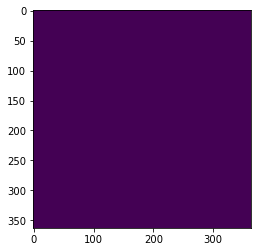

In [13]:
prior = get_prior_pgram(seg)
plt.imshow(prior)

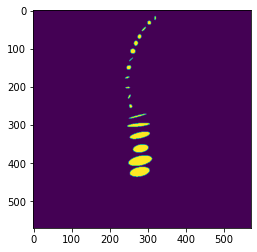

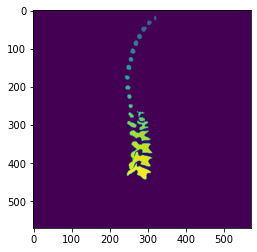

In [60]:
prior = np.zeros_like(seg)
for i in np.unique(seg):
    slice = copy.deepcopy(seg)
    slice[slice!=i]=0
    prior += get_prior(slice)
prior[prior>1]=1
plt.imshow(prior)
plt.show()
plt.imshow(seg)
plt.show()

In [61]:
np.unique (prior)

array([0., 1.])

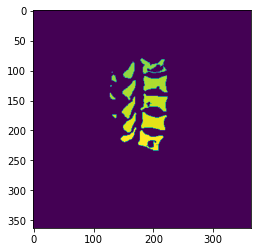

In [24]:
plt.imshow(seg)

In [7]:
pbar = tqdm(total=len(img_files), desc = 'Completed', leave=False)
main_path_new = '/home/rahulroy/Segmentation_DA_MSD/data/SpineCT_processed/train/'
count = 0
for i in img_files:
    # print(i)
    seg_full = nib.load(main_path+'WholeMask/'+i)
    seg_full = seg_full.get_fdata()
    seg_lumbar =  nib.load(main_path+'Mask/'+i)
    seg_lumbar = seg_lumbar.get_fdata()
    if len(np.unique(seg_full))>2:
        img = nib.load(main_path+'Image/'+i)
        img = img.get_fdata()
        count+=1
        seg_full = np.array(Image.fromarray(seg_full).resize(size = (512, 512), resample = Image.NEAREST))
        seg_lumbar = np.array(Image.fromarray(seg_lumbar).resize(size = (512, 512), resample = Image.NEAREST))
        img = np.array(Image.fromarray(img).resize(size = (512, 512), resample = Image.NEAREST))
        seg_left = copy.deepcopy(seg_lumbar)
        seg_complete = copy.deepcopy(seg_full)
        seg_right = copy.deepcopy(seg_full)
        seg_right[seg_lumbar!=0] = 0
        seg_complete[seg_complete>=1] = 1
        seg_right[seg_right>=1] = 1
        seg_left[seg_left>=1] = 1
        seg_f = copy.deepcopy(seg_full)
        seg_r = copy.deepcopy(seg_full)
        seg_f[seg_lumbar!=0] = 1
        seg_f[seg_lumbar==0] = 0
        seg_r[seg_full!=0] = 2
        seg_r[seg_lumbar!=0] = 0
        seg_full = seg_f + seg_r
        np.save(main_path_new+'imagesTr/'+str(count)+'.npy', img)
        np.save(main_path_new+'labelsTr/'+str(count)+'.npy', seg_full)
        np.save(main_path_new+'labels_right/'+str(count)+'.npy', seg_right)
        np.save(main_path_new+'labels_left/'+str(count)+'.npy', seg_left)
        np.save(main_path_new+'labels_comp/'+str(count)+'.npy', seg_complete)
        pbar.update(1)
        # plot_priors(seg_full,seg_left,seg_right,seg_complete)
        # print(np.unique(seg_full), np.unique(seg_left), np.unique(seg_right), np.unique(seg_complete))



Completed:  29%|██▉       | 8439/28915 [19:14<15:00, 22.74it/s]

Completed:   0%|          | 0/28915 [00:00<?, ?it/s]ipykernel_launcher:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning

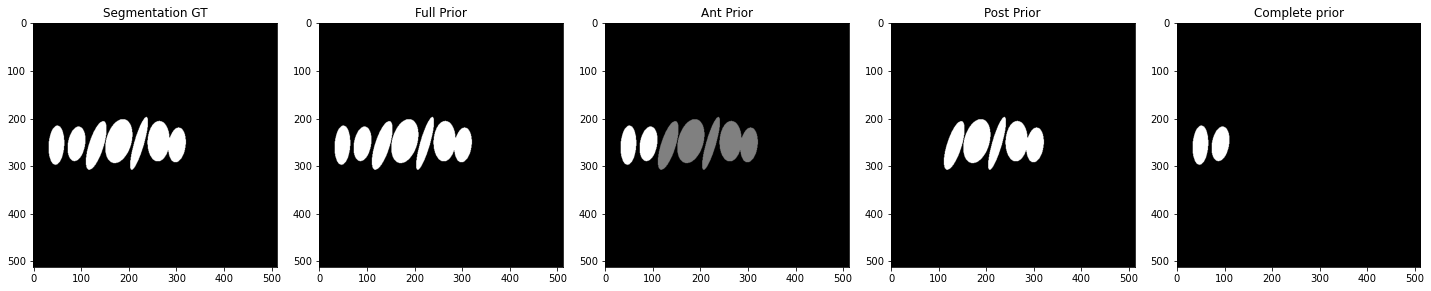

In [9]:
pbar = tqdm(total=len(img_files), desc = 'Completed', leave=False)
for i in img_files[0:10]:
    # print(i)
    seg_full = nib.load(main_path+'WholeMask/'+i)
    seg_full = seg_full.get_fdata()
    seg_lumbar =  nib.load(main_path+'Mask/'+i)
    seg_lumbar = seg_lumbar.get_fdata()
    if len(np.unique(seg_full))>2:
        img = nib.load(main_path+'Image/'+i)
        img = img.get_fdata()
        count+=1
        seg_full = np.array(Image.fromarray(seg_full).resize(size = (512, 512), resample = Image.NEAREST))
        seg_lumbar = np.array(Image.fromarray(seg_lumbar).resize(size = (512, 512), resample = Image.NEAREST))
        img = np.array(Image.fromarray(img).resize(size = (512, 512), resample = Image.NEAREST))
        prior = np.zeros_like(seg_full)
        for i in np.unique(seg_full):
            slice = copy.deepcopy(seg_full)
            slice[slice!=i]=0
            prior += get_prior(slice)
        prior[prior>1]=1
        prior_lumb = np.zeros_like(seg_lumbar)
        for i in np.unique(seg_lumbar):
            slice = copy.deepcopy(seg_lumbar)
            slice[slice!=i]=0
            prior_lumb += get_prior(slice)
        prior_lumb[prior_lumb>1]=1
        prior_right = prior - prior_lumb
        prior_r = copy.deepcopy(prior_right)
        prior_r[prior_r!=0] = 2
        prior_full = prior_r + prior_lumb
        plot_priors(prior, prior_full, prior_lumb, prior_right)
        break


        

In [4]:
main_path = '..//data/SpineCT_processed/train/'
img_files = sorted(os.listdir(main_path+'imagesTr'))
seg_files = sorted(os.listdir(main_path+'labelsTr'))



0.0 0.47980997


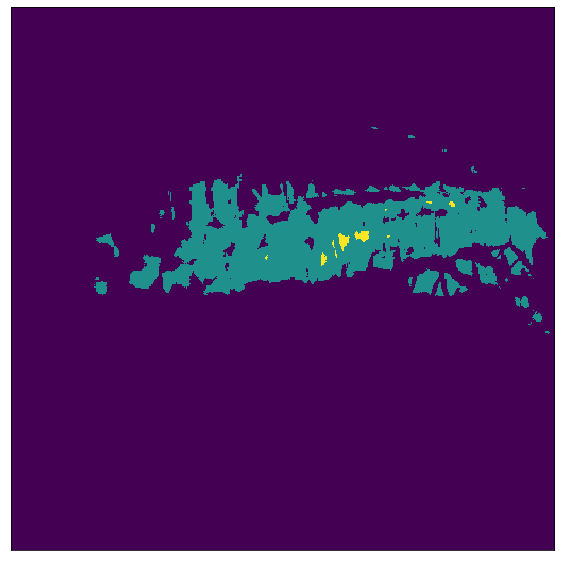

0.0 0.39739028


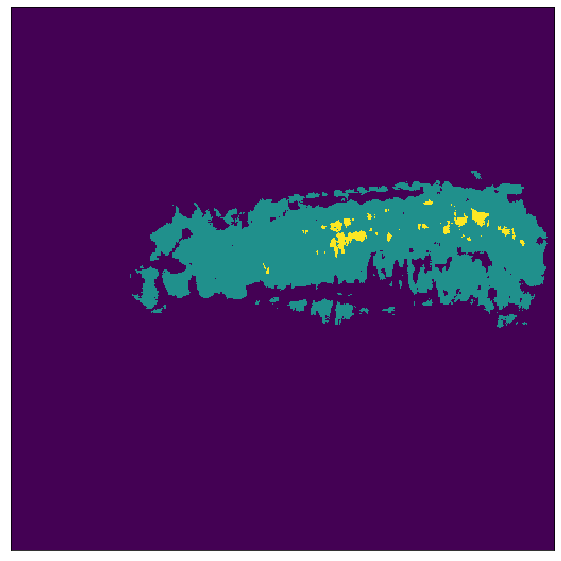

0.0 0.34795496


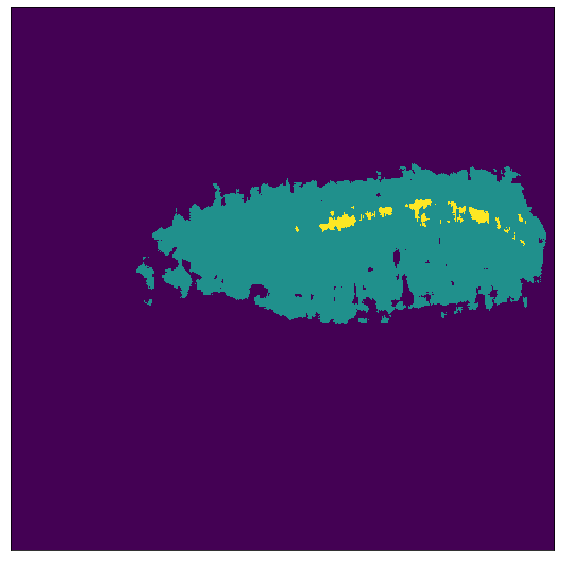

0.0 0.32951403


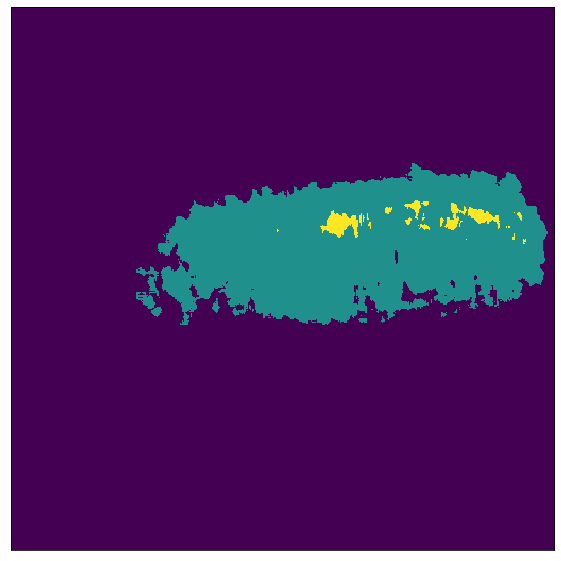

0.0 0.2797037


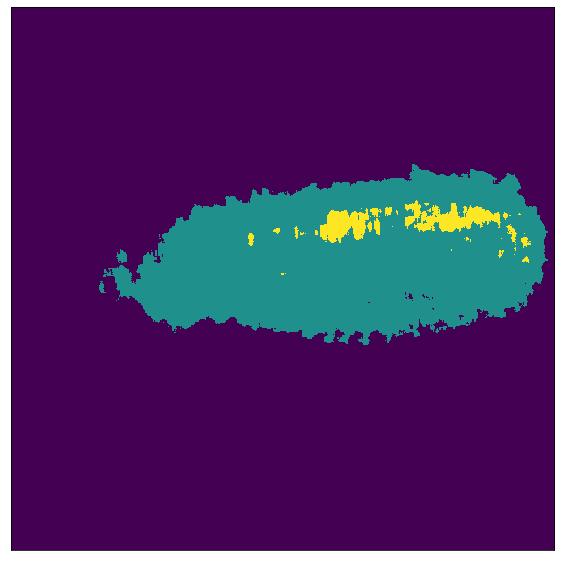

0.0 0.2711543


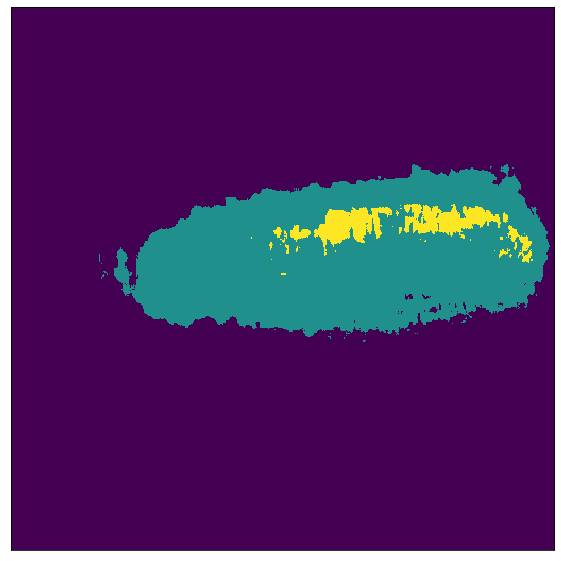

In [8]:
for tr in [0.1, 0.2, 0.4, 0.6, 0.8, 1]:
    for count, i in enumerate(seg_files[0:int(tr*(len(seg_files)))]):
        seg = np.load(main_path+'labelsTr/'+i)
        if count==0:
            mean_sp = seg
        else:
            mean_sp += seg
    mean_sp/=count
    print(np.min(mean_sp), np.max(mean_sp))
    mean_sp *= (2/np.max(mean_sp))
    mean_sp[mean_sp<0.5] = 0
    mean_sp[(mean_sp>=0.5) & (mean_sp <=1.5)] = 1
    mean_sp[mean_sp>1.5] = 2
    fig = plt.figure(figsize=(10,10))
    plt.imshow(mean_sp)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    fig.savefig('../mean_priors_spine/'+str(tr)+'meanSP.png')
    count = 0
    np.save('../mean_priors_spine/'+str(tr)+'meanSP.npy', mean_sp)

In [12]:
main_path = '../data/SpineCT_processed/train/prior/'
# img_files = sorted(os.listdir(main_path+'imagesTr'))
seg_files = sorted(os.listdir(main_path+'full'))
for count, i in enumerate(seg_files):
    seg = np.load(main_path+'full/'+i)
    print(np.unique(seg))

[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0.

KeyboardInterrupt: 